# Hertzsprung-Russell Diagram

> The Hertzsprung–Russell diagram, abbreviated H–R diagram or HRD, is a scatter graph of stars showing the relationship between the stars' absolute magnitudes or luminosities versus their spectral classifications or effective temperatures. More simply, it plots each star on a graph measuring the star's brightness against its temperature (color). It does not map any locations of stars.
>
> --[_Wikipedia_](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram)

Based on [zonination's original work](https://www.reddit.com/r/dataisbeautiful/comments/433960).

Data from the [HYG star database archive](https://github.com/astronexus/HYG-Database).

## Step 1: Download the data and clean it

In [1]:
!curl -O https://raw.githubusercontent.com/astronexus/HYG-Database/master/hygdata_v3.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.9M  100 31.9M    0     0  4577k      0  0:00:07  0:00:07 --:--:-- 5885k


In [2]:
!ls -l | grep hyg

-rw-r--r--. 1 rober rober 33449663 May  5 18:31 hygdata_v3.csv


In [3]:
import pandas as pd

# The H-R diagram only shows the absolute magnitude and the color index.
# Every other column is discarded, and the ones with null values are dropped.
df = pd.read_csv('hygdata_v3.csv')[['absmag', 'ci']]
df.dropna(inplace=True) # drops 1882 rows

print '%i total rows' % len(df)
df.head(3)

117732 total rows


,absmag,ci
0,4.850,0.656
1,2.390,0.482
2,5.866,0.999


## Step 2: Explore the data

In [4]:
%matplotlib inline

Seaborn is way easier for these kinds of plots, so we leave out matplotlib for a while.

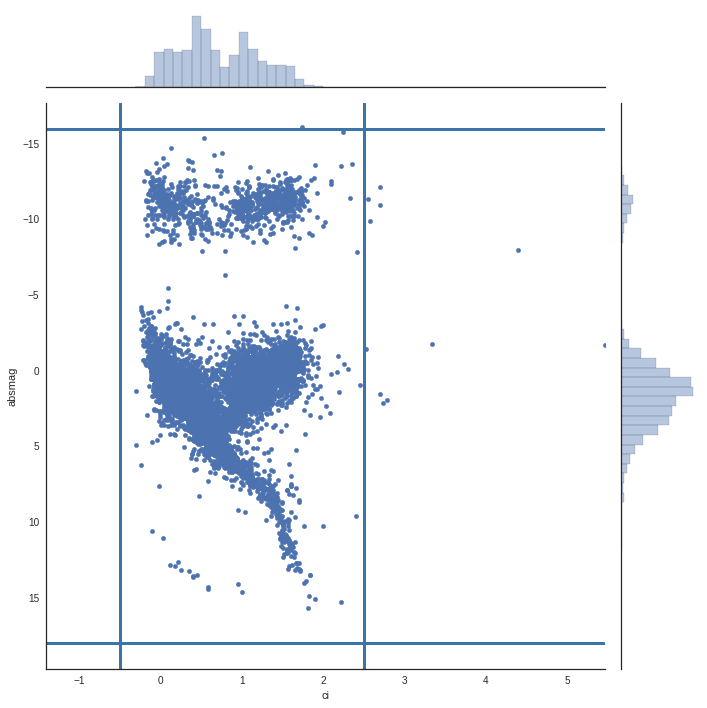

In [5]:
import seaborn as sns
sns.set(style="white")

xlim = (min(df['ci']) - 1, max(df['ci']))
ylim = (max(df['absmag']) + 1, min(df['absmag']) - 1) # inverts y-axis

ax = sns.jointplot(
    x="ci", y="absmag", data=df.sample(10e3),
    xlim=xlim, ylim=ylim,
    size=10, ratio=6,
    stat_func=None)

for x, y in [([2.5, 2.5], ylim), ([-.5, -.5], ylim), (xlim, [18, 18]), (xlim, [-16, -16])]:
    ax.ax_joint.plot(x, y, sns.xkcd_rgb["flat blue"], lw=3)

The distribution of the data points in both variables allows for the definition of cutoff points delimiting the zones of high data density. The points belonging to these regions will be plotted, discarding the rest as outliers.

## Step 3: Plot the data

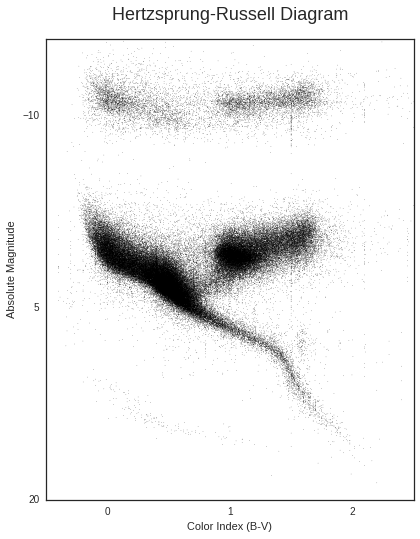

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(
    figsize=(6, 8),
    dpi=72)
# Leave room for axis labels and title.
# http://stackoverflow.com/a/19576608
ax = fig.add_axes([.1, .1, .85, .8])

ax.set_title('Hertzsprung-Russell Diagram', fontsize=18)
# Move title by treating it as a simple text instance
# http://stackoverflow.com/a/16420635/3402367
ax.title.set_position([.5, 1.03])
ax.set_xlabel('Color Index (B-V)')
ax.set_ylabel('Absolute Magnitude')

ax.scatter(
    df['ci'],
    df['absmag'],
    marker='.',
    # define marker size
    # http://stackoverflow.com/a/14860958/3402367
    s=[1] * len(df),
    facecolors='black',
    linewidth=0)

ax.set_xlim(-.5, 2.5)
ax.set_xticks(np.linspace(0, 2, 3, endpoint=True))
ax.set_ylim(18, -16)
ax.set_yticks(np.linspace(20, -10, 3, endpoint=True))

# uncomment to save figure
#plt.savefig("Hertzsprung-Russell.png", dpi=72)

## Step 4: Style the data

Conversion of B-V Color Index to sRGB, following a [StackOverflow post by melhosseiny](http://stackoverflow.com/q/21977786) and translating the solution to Python. The gamma values have been slightly tweaked for better results.

In [7]:
def bv2rgb(bv):
    t = (5000 / (bv + 1.84783)) + (5000 / (bv + .673913))
    x, y = 0, 0
    
    if 1667 <= t <= 4000:
        x = .17991 - (2.66124e8 / t**3) - (234358 / t**2) + (877.696 / t)
    elif 4000 < t:
        x = .24039 - (3.02585e9 / t**3) + (2.10704e6 / t**2) + (222.635 / t)
        
    if 1667 <= t <= 2222:
        y = (-1.1063814 * x**3) - (1.34811020 * x**2) + 2.18555832 * x - .20219683
    elif 2222 < t <= 4000:
        y = (-.9549476 * x**3) - (1.37418593 * x**2) + 2.09137015 * x - .16748867
    elif 4000 < t:
        y = (3.0817580 * x**3) - (5.87338670 * x**2) + 3.75112997 * x - .37001483
        
    X = 0 if y == 0 else x / y
    Z = 0 if y == 0 else (1 - x - y) / y
    
    r, g, b = np.dot([X, 1., Z],
        [[3.2406, -.9689, .0557], [-1.5372, 1.8758, -.204], [-.4986, .0415, 1.057]])
    
    R = np.clip(12.92 * r if (r <= 0.0031308) else 1.4 * (r**2 - .285714), 0, 1)
    G = np.clip(12.92 * g if (g <= 0.0031308) else 1.4 * (g**2 - .285714), 0, 1)
    B = np.clip(12.92 * b if (b <= 0.0031308) else 1.4 * (b**2 - .285714), 0, 1)
    
    return [R, G, B, 1]

color = df['ci'].apply(bv2rgb)

## Step 5: Animate the data